# Machine Translation + Transformer

In [2]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [3]:
torch.__version__

'2.1.0+cu121'

In [4]:
torchtext.__version__

'0.16.0+cpu'

## 1. ETL: Loading the dataset

The dataset is available on hugging face as OPUS100 repo.

In [5]:
from datasets import load_dataset

dataset = load_dataset("opus100",'en-ne')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/406381 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 406381
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

## 2. EDA - simple investigation

In [10]:
#let's take a look at one example of train
sample = next(iter(dataset['train']))
sample

{'ne': 'मिलेका रेखाहरुको माथि पिक्सलहरु', 'en': 'Pixels above lines set'}

In [11]:
train_size = len(list(iter(dataset['train'])))
train_size

200000

In [12]:
dataset

DatasetDict({
    test: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
})

## 3. Preprocessing

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line:
```
python3 -m spacy download en_core_web_sm
```


For Nepali language, we will be using Nepali tokenizer libaray, open sourced avaialble at: https://pypi.org/project/nepalitokenizer/

In [13]:
token_transform = {}
vocab_transform = {}

In [14]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'ne'

In [17]:
from torchtext.data.utils import get_tokenizer
from nepalitokenizers import WordPiece

In [18]:
token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform["ne"] = WordPiece()

In [109]:
#Tokenization of the english part
print("Sentence: ", dataset['train']['ne'][10])

#Tokenization of the nepali part
print("Tokenization: ", token_transform['ne'].encode(dataset['train']['ne'][10]).tokens)

Sentence:  मद्दत दृश्यकर्ता सुरुआत गर्दा त्यहाँ त्रुटि थियो: %s
Tokenization:  ['[CLS]', 'मद्दत', 'दृश्य', '##कर्ता', 'सुरुआत', 'गर्दा', 'त्यहाँ', 'त्रुटि', 'थियो', ':', '%', 's', '[SEP]']


In [21]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [22]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(tokenized_dataset['train'][ln],
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [110]:
#see some example
vocab_transform[SRC_LANGUAGE](['today', 'there'])

[986, 146]

In [26]:
#we can reverse it....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

#print 1816, for example
mapping[111]

'गर्दछ'

In [27]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [28]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [29]:
#check unique vocabularies
len(mapping)

10048

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [30]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# Define a helper function to combine sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        # Iterate over the provided transformations
        for transform in transforms:
            try:
                # Apply the transformation to the text input
                txt_input = transform(txt_input)
            except:
                # If an exception occurs (e.g., if the transform is an encoding operation), catch it
                txt_input = transform.encode(txt_input).tokens
        # Return the transformed text input
        return txt_input
    # Return the function that applies sequential transformations
    return func


# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [31]:
# Set the batch size for data loaders
batch_size = 64

# Create DataLoader for the training set
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# Create DataLoader for the validation set
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Create DataLoader for the test set
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [32]:
## Dividing test loader into its language counterparts
for ne, _, en in train_loader:
    break

In [33]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Nepali shape: ", ne.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 5])
Nepali shape:  torch.Size([64, 3])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [34]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [35]:
## Added attention variant to see which variant we need to work with
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        ## Attention variant
        self.attn_variant = attn_variant
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src

### Mutli Head Attention Layer

In [36]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super(AdditiveAttention, self).__init__()

        # Linear layers for additive attention
        self.Wa = nn.Linear(head_dim, head_dim)
        self.Ua = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, query, keys):
        # Add singleton dimensions for broadcasting
        query = query.unsqueeze(3)
        keys = keys.unsqueeze(2)

        # Apply additive attention mechanism
        features = torch.tanh(self.Wa(query) + self.Ua(keys))

        # Calculate attention scores
        scores = self.V(features).squeeze(-1)

        return scores


In [37]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attn_variant, device):
        super().__init__()
        assert hid_dim % n_heads == 0

        # Initialize parameters
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_variant = attn_variant

        # Linear transformations for query, key, value, and output
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Scale factor for attention scores
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        # Initialize additive attention mechanism
        self.additive_attention = AdditiveAttention(self.head_dim)

    def forward(self, query, key, value, mask=None):
        # Shapes: query = [batch size, query len, hid dim], key = [batch size, key len, hid dim], value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        # Apply linear transformations to query, key, and value
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape and permute for multi-head attention
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Calculate attention scores based on the selected attention variant
        if self.attn_variant == "multiplicative":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        elif self.attn_variant == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        elif self.attn_variant == "additive":
            energy = self.additive_attention(Q, K)

        else:
            raise Exception("Incorrect value for attention variant. Must be one of the following: multiplicative, additive, general")

        # Mask attention scores if a mask is provided
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Apply softmax to obtain attention weights
        attention = torch.softmax(energy, dim=-1)

        # Perform weighted sum using attention weights
        x = torch.matmul(attention, V)

        # Transpose and reshape to the original shape
        x = x.transpose(-1, -2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)

        # Apply linear transformation for the final output
        x = self.fc_o(x)

        return x, attention

### Position-wise Feedforward Layer

In [38]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

In [39]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [40]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [41]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        ## store params to make use of model easier
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [42]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [43]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
## Passing of attention variant
attn_variant = 'additive'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(17167, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [44]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

4394752
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
2572288
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [45]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [46]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [47]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [48]:
dataset['validation'][2]

{'ne': 'सम्पादनबिहिन लेखक', 'en': 'Non-repudiation'}

In [49]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## All three Model Training

In [50]:
import gc

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
## low learning rate in order to increase model complexity
lr = 0.0000001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 5
clip       = 1
## Attention variant is passed as a list
for attn_variant in ['general', 'multiplicative', 'additive']:

    train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    train_loader_length = len(list(iter(train_loader)))
    val_loader_length   = len(list(iter(valid_loader)))
    test_loader_length  = len(list(iter(test_loader)))

    enc = Encoder(input_dim,
                  hid_dim,
                  enc_layers,
                  enc_heads,
                  enc_pf_dim,
                  enc_dropout,
                  attn_variant,
                  device)

    dec = Decoder(output_dim,
                  hid_dim,
                  dec_layers,
                  dec_heads,
                  dec_pf_dim,
                  enc_dropout,
                  attn_variant,
                  device)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    #training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

    save_path = f'{attn_variant}_{model.__class__.__name__}.pt'

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n===== {attn_variant} =====')

    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)


        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


===== general =====
Epoch: 01 | Time: 1m 49s
	Train Loss: 8.907 | Train PPL: 7380.393
	 Val. Loss: 8.122 |  Val. PPL: 3368.854
Epoch: 02 | Time: 1m 46s
	Train Loss: 8.141 | Train PPL: 3433.243
	 Val. Loss: 7.244 |  Val. PPL: 1399.904
Epoch: 03 | Time: 1m 47s
	Train Loss: 7.447 | Train PPL: 1715.168
	 Val. Loss: 6.657 |  Val. PPL: 778.501
Epoch: 04 | Time: 1m 46s
	Train Loss: 6.897 | Train PPL: 989.401
	 Val. Loss: 6.213 |  Val. PPL: 499.268
Epoch: 05 | Time: 1m 46s
	Train Loss: 6.473 | Train PPL: 647.577
	 Val. Loss: 5.869 |  Val. PPL: 353.903

===== multiplicative =====
Epoch: 01 | Time: 1m 51s
	Train Loss: 8.536 | Train PPL: 5097.091
	 Val. Loss: 7.501 |  Val. PPL: 1809.349
Epoch: 02 | Time: 1m 49s
	Train Loss: 7.538 | Train PPL: 1877.474
	 Val. Loss: 6.698 |  Val. PPL: 811.034
Epoch: 03 | Time: 1m 49s
	Train Loss: 6.910 | Train PPL: 1002.026
	 Val. Loss: 6.213 |  Val. PPL: 499.263
Epoch: 04 | Time: 1m 50s
	Train Loss: 6.473 | Train PPL: 647.724
	 Val. Loss: 5.865 |  Val. PPL: 352.3

### Experiment with Attention Mechanism

| Attention Variant | Training Loss | Training PPL | Validation Loss | Validation PPL |
|-------------------|---------------|--------------|------------------|-----------------|
| General           | 6.473         | 647.577      | 5.869            |  353.903           |
| Multiplicative    | 6.140         | 464.050      | 5.595            | 269.178             |
| Additive          | 6.237         | 511.191      | 5.682            | 293.679            |

In [51]:
# Create DataLoader for training data with batching and shuffling
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# Create DataLoader for validation data with batching (no shuffling during validation)
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Create DataLoader for test data with batching (no shuffling during testing)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Calculate the number of batches in each DataLoader
train_loader_length = len(list(iter(train_loader)))
val_loader_length = len(list(iter(valid_loader)))
test_loader_length = len(list(iter(test_loader)))


In [52]:
import gc
import time
import math

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])


batch_size = 32
lr = 0.0000001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))


num_epochs = 5
clip       = 1

###  Evaluation and Verification

#### General Model Training

In [53]:
## Working with general attention
attn_variant = "general"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses_general = []
valid_losses_general = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses_general.append(train_loss)
    valid_losses_general.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_general
final_train_loss = train_losses_general[-1]
final_valid_loss = valid_losses_general[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### general #####
Epoch: 01 | Time: 3m 10s
	Train Loss: 8.436 | Train PPL: 4607.902
	Val. Loss: 7.226 | Val. PPL: 1374.742
Epoch: 02 | Time: 3m 9s
	Train Loss: 7.148 | Train PPL: 1271.773
	Val. Loss: 6.219 | Val. PPL: 502.088
Epoch: 03 | Time: 3m 14s
	Train Loss: 6.303 | Train PPL: 546.164
	Val. Loss: 5.590 | Val. PPL: 267.684
Epoch: 04 | Time: 3m 12s
	Train Loss: 5.741 | Train PPL: 311.235
	Val. Loss: 5.161 | Val. PPL: 174.412
Epoch: 05 | Time: 3m 12s
	Train Loss: 5.333 | Train PPL: 206.957
	Val. Loss: 4.842 | Val. PPL: 126.683
Final Training Loss: 5.333 | Final Validation Loss: 4.842 | Final Train PPL 206.957 | Final Valid PPL 126.683 | Average Time per epoch (192.11527338027955,) | Overall time 0.030738443740844727


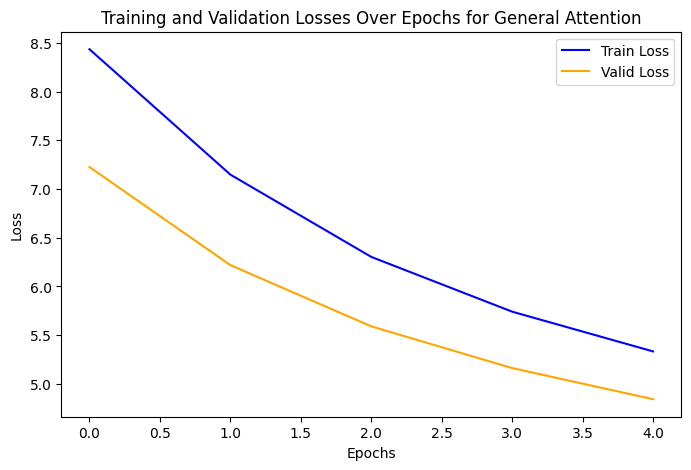

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_general, label='Train Loss', color='blue')
ax.plot(valid_losses_general, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for General Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [55]:
# Path to the saved model file
save_path = 'general_Seq2SeqTransformer.pt'

# Load the model parameters and state
params, state = torch.load(save_path)

# Initialize the Seq2SeqTransformer model using the loaded parameters and move it to the specified device
model = Seq2SeqTransformer(**params, device=device).to(device)

# Load the model state
model.load_state_dict(state)

# Evaluate the model on the test data and calculate the test loss
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# Print the test loss and test perplexity
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


| Test Loss: 5.869 | Test PPL: 353.903 |


#### Training with Multiplicative Model

In [56]:
## Working with multiplicative attention
attn_variant = "multiplicative"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model_multiplicative.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)


best_valid_loss = float('inf')
train_losses_multiplicative = []
valid_losses_multiplicative = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model_multiplicative, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_multiplicative, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses_multiplicative.append(train_loss)
    valid_losses_multiplicative.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses_multiplicative
final_train_loss = train_losses_multiplicative[-1]
final_valid_loss = valid_losses_multiplicative[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### multiplicative #####
Epoch: 01 | Time: 3m 15s
	Train Loss: 8.067 | Train PPL: 3188.766
	Val. Loss: 6.735 | Val. PPL: 841.504
Epoch: 02 | Time: 3m 14s
	Train Loss: 6.717 | Train PPL: 826.713
	Val. Loss: 5.851 | Val. PPL: 347.539
Epoch: 03 | Time: 3m 11s
	Train Loss: 6.018 | Train PPL: 410.690
	Val. Loss: 5.366 | Val. PPL: 213.981
Epoch: 04 | Time: 3m 12s
	Train Loss: 5.560 | Train PPL: 259.807
	Val. Loss: 5.031 | Val. PPL: 153.082
Epoch: 05 | Time: 3m 12s
	Train Loss: 5.212 | Train PPL: 183.397
	Val. Loss: 4.759 | Val. PPL: 116.630
Final Training Loss: 5.212 | Final Validation Loss: 4.759 | Final Train PPL 183.397 | Final Valid PPL 116.630 | Average Time per epoch (193.21209349632264,) | Overall time 0.03091393495941162


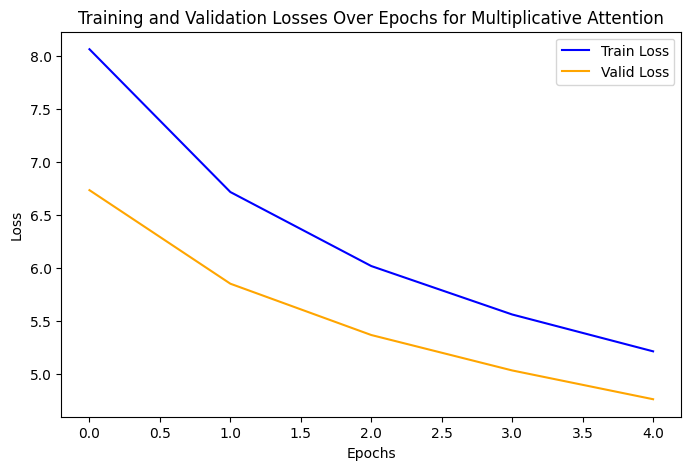

In [57]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_multiplicative, label='Train Loss', color='blue')
ax.plot(valid_losses_multiplicative, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for Multiplicative Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [58]:
save_path = 'multiplicative_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.595 | Test PPL: 269.178 |


#### Training with Additive Model

In [59]:
# Working with additive attention
attn_variant = "additive"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0  # Variable to store the total time taken for all epochs

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

# Record all final losses
final_train_loss = train_losses[-1]
final_valid_loss = valid_losses[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

# Calculate time taken for the traning
average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### additive #####
Epoch: 01 | Time: 3m 42s
	Train Loss: 8.156 | Train PPL: 3482.518
	Val. Loss: 6.742 | Val. PPL: 847.295
Epoch: 02 | Time: 3m 42s
	Train Loss: 6.755 | Train PPL: 858.436
	Val. Loss: 5.842 | Val. PPL: 344.485
Epoch: 03 | Time: 3m 42s
	Train Loss: 6.037 | Train PPL: 418.812
	Val. Loss: 5.345 | Val. PPL: 209.659
Epoch: 04 | Time: 3m 43s
	Train Loss: 5.567 | Train PPL: 261.765
	Val. Loss: 5.008 | Val. PPL: 149.633
Epoch: 05 | Time: 3m 43s
	Train Loss: 5.211 | Train PPL: 183.319
	Val. Loss: 4.736 | Val. PPL: 113.977
Final Training Loss: 5.211 | Final Validation Loss: 4.736 | Final Train PPL 183.319 | Final Valid PPL 113.977 | Average Time per epoch (222.92789816856384,) | Overall time 0.035668463706970216


In [60]:
save_path = 'additive_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.682 | Test PPL: 293.679 |


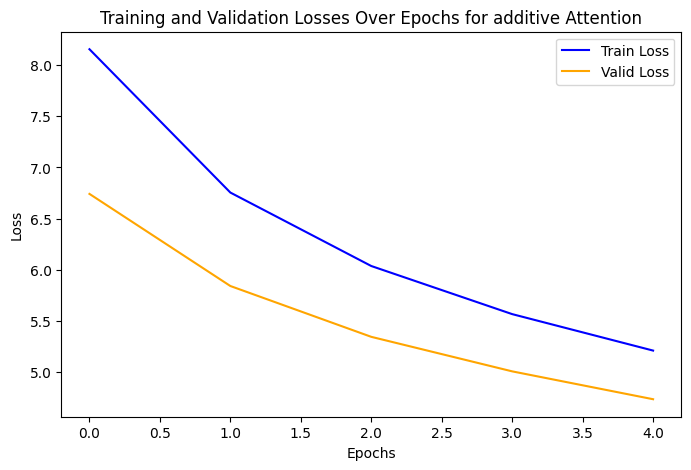

In [61]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses, label='Train Loss', color='blue')
ax.plot(valid_losses, label='Valid Loss', color='orange')

# Add title, labels, and legend
plt.title('Training and Validation Losses Over Epochs for additive Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


## 7 Testing

### 7.1 Test with additive model

In [71]:
import os
# let's pick one of our model, in this case the additive model
load_path = 'additive_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
# Record the start time
start_time = time.time()
model.eval()
with torch.no_grad():
    output, attentions_additive = model(src_text, trg_text) #turn off teacher forcing
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print or use the elapsed time as needed
print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.06071591377258301 seconds
Model size: 52.69 MB


## 7.2 Test with Multiplicative Model

In [81]:
import os
# let's pick one of our model, in this case the additive model
load_path = 'general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()
# Record the start time
start_time = time.time()
with torch.no_grad():
    output, attentions_multiplicative = model(src_text, trg_text) #turn off teacher forcing
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print or use the elapsed time as needed
print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")


Time taken for inference: 0.014584064483642578 seconds
Model size: 52.69 MB


## 7.3 Test with General Model

In [89]:
import os
# let's pick one of our model, in this case the additive model
load_path = 'general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()
# Record the start time
start_time = time.time()
with torch.no_grad():
    output, attentions_general = model(src_text, trg_text) #turn off teacher forcing
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print or use the elapsed time as needed
print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")


Time taken for inference: 0.024532556533813477 seconds
Model size: 52.69 MB


### Performance Analysis

| Attention Variant |  Inference Time | Model Size (MB)| 
|-------------------|------------------------|--------------|
| General           |        0.02    |  52.69        |   
| Multiplicative    |         0.041    |  52.69         |    
| Additive          |           0.060    |  52.69         | 


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [98]:
attentions_additive.shape, attentions_general.shape, attentions_multiplicative.shape

(torch.Size([1, 8, 7, 3]), torch.Size([1, 8, 7, 3]), torch.Size([1, 8, 7, 3]))

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [99]:
# Extract attention matrices for the additive, general, and multiplicative attention mechanisms
attention_additive = attentions_additive[0, 0, :, :]
attention_general = attentions_general[0, 0, :, :]
attention_multiplicative = attentions_general[0, 0, :, :]

# Print or use the shapes of the attention matrices as needed
print(attention_additive.shape, attentions_general.shape, attention_multiplicative.shape)


torch.Size([7, 3]) torch.Size([1, 8, 7, 3]) torch.Size([7, 3])


In [100]:
# Construct source tokens by adding start-of-sequence and end-of-sequence tokens
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](dataset['test'][1]['en']) + ['<eos>']

# Print or use the source tokens as needed
print(src_tokens)


['<sos>', 'Treize', '<eos>']


In [101]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>', 'en', '##णि', 'मेरुदण्ड', '##ി', '##्रा', 'en']

### Attention Maps

In [102]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.set_title(title)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


<ipython-input-102-6793984bf5a7>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-102-6793984bf5a7>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missin

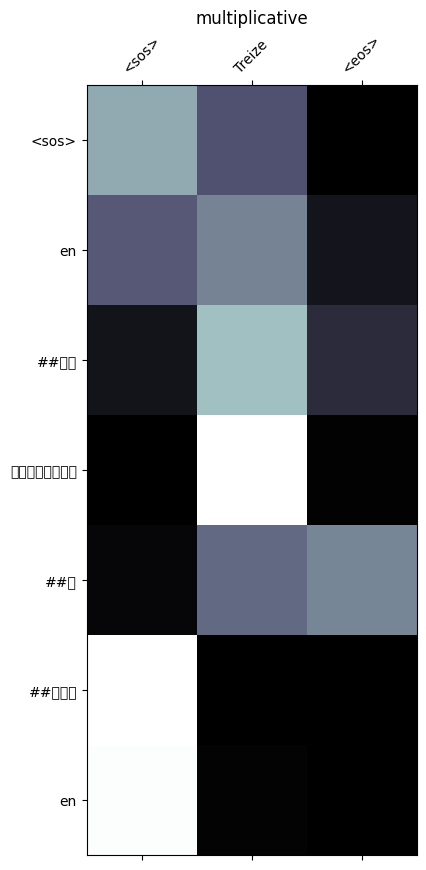

In [103]:
display_attention(src_tokens, trg_tokens, attention_multiplicative, "multiplicative")

<ipython-input-102-6793984bf5a7>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-102-6793984bf5a7>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


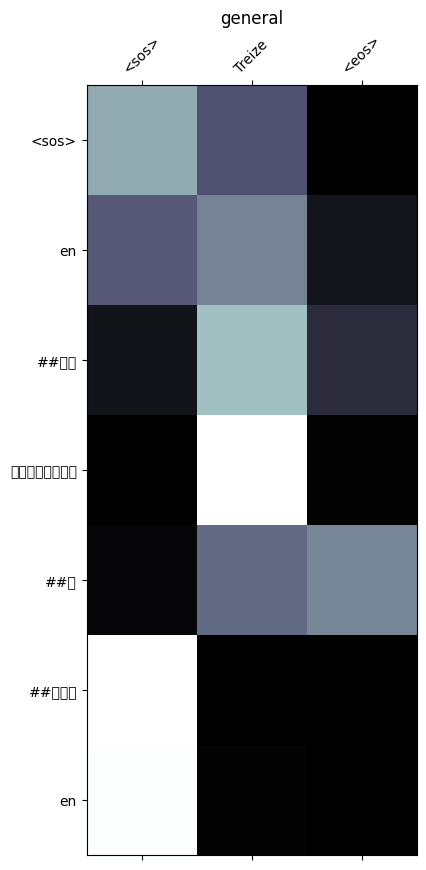

In [104]:
display_attention(src_tokens, trg_tokens, attention_general, "general")

<ipython-input-102-6793984bf5a7>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-102-6793984bf5a7>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


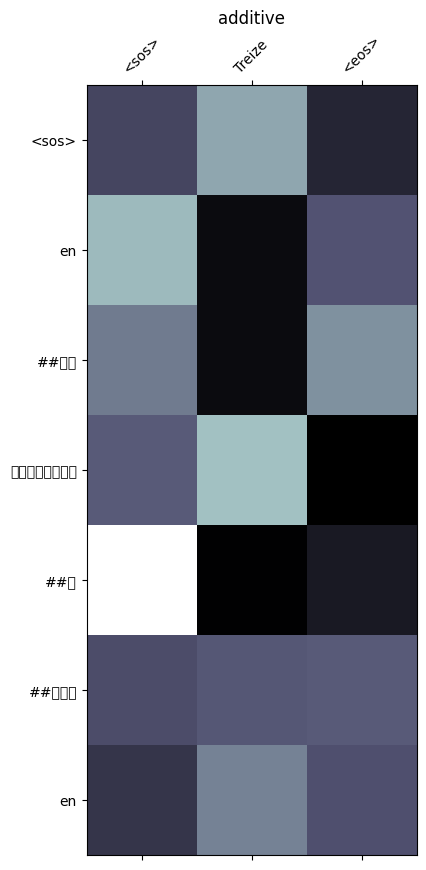

In [105]:
display_attention(src_tokens, trg_tokens, attention_additive, "additive")